# Imports

In [9]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from category_encoders import LeaveOneOutEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt

from functions_pkg import print_vif, predictions_df
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline
plt.style.use(["dark_background"])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

* Categorical or continuous
* 10,000+ samples
* 20+ features

age = days (int)

In [11]:
path = "cardiovascular_disease_prediction/cardio_train.csv"
df = pd.read_csv(path, sep=";", index_col="id")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# df.head()

In [12]:
# column renaming
mapping = {
    "ap_hi": "bp_hi",
    "ap_lo": "bp_lo",
    "gluc": "glucose",
    "alco": "alcohol",
    "cardio": "disease",
}

df = df.rename(columns=mapping)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
df.disease.value_counts()

0    35021
1    34979
Name: disease, dtype: int64

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# df.isna().mean().sort_values(ascending=False)

# Data Cleaning

In [14]:
# change gender to 0-1 binary
df.loc[:, "gender"] = df.gender - 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
# reduce interval in cholesterol & glucose from 1-3 to 0-2
df.loc[:, "cholesterol"] = df.cholesterol - 1
df.loc[:, "glucose"] = df.glucose - 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Features

In [16]:
# blood pressure difference column
df["bp_diff"] = df.bp_hi - df.bp_lo

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
# BMI column to replace height and weight
# bmi = weight (kgs) / (height (m))^2
df["bmi"] = df.weight / (df.height / 100) ** 2

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
# drop height and weight columns from df
df = df.drop(columns=["height", "weight"])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Exploration

In [19]:
num_cols = ["age", "bp_hi", "bp_lo", "bp_diff", "bmi"]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

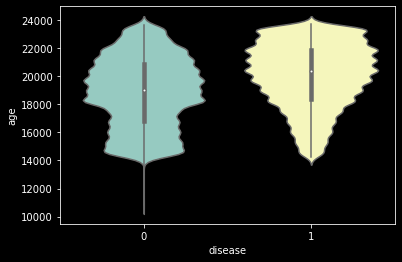

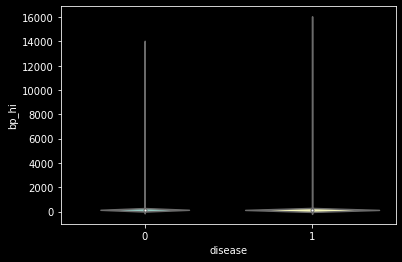

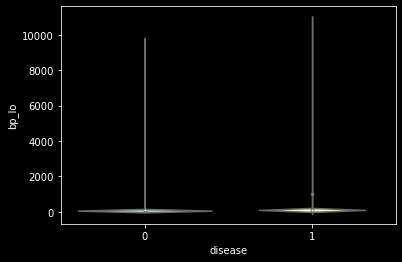

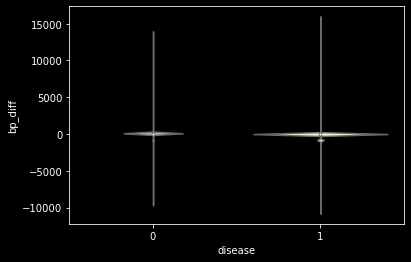

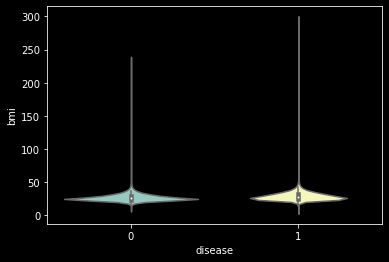

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
# df_sample = df.sample(frac=0.1, replace=True, random_state=28, axis="index")

for col in num_cols:
    sns.violinplot(x="disease", y=col, data=df)
    plt.show()

# Modeling

> ### testing sets

In [27]:
X = df.drop(columns="disease")
y = df.disease

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=28, stratify=df.disease
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
bin_cols = ["gender", "smoke", "alcohol", "active"]
num_cols = ["age", "bp_hi", "bp_lo", "bp_diff", "bmi"]
cat_cols = ["cholesterol", "glucose"]
# drop_cats = [0]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

> ### preprocessing

In [23]:
# fmt: off
preprocessing = ColumnTransformer(
    [
        ("encode_cats", LeaveOneOutEncoder(), cat_cols),
        ("scaler", StandardScaler(), num_cols),
#        ("scaler", MinMaxScaler(), num_cols),
    ],
    remainder="passthrough",
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

> ### pipeline

In [24]:
# fmt: off
pipeline = Pipeline(
    [
        ("processing", preprocessing),
        ("model", KNeighborsClassifier())
    ]
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Hyperparameter Optimization

In [28]:
grid = {
    "model__n_neighbors": [5, 10, 15, 20, 25, 30],
    "model__weights": ["uniform", "distance"],
}

model = GridSearchCV(pipeline, grid, verbose=1, cv=5, n_jobs=-1)
model.fit(X_train, y_train)

best_params = model.best_params_
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"parameters: {best_params}")
print("=======================================")
print(f"train score: {train_score}")
print(f"test score: {test_score}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.1min finished


parameters: {'model__n_neighbors': 25, 'model__weights': 'uniform'}
train score: 0.7241785714285714
test score: 0.7004285714285714


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
# parameters: {'model__n_neighbors': 25, 'model__weights': 'uniform'}
# =======================================
# train score: 0.7241785714285714
# test score: 0.7004285714285714

## Optimized Parameters

In [29]:
# fmt: off
pipeline = Pipeline(
    [
        ("processing", preprocessing),
        ("model", KNeighborsClassifier(n_neighbors=25, weights='uniform'))
    ]
)

pipeline.fit(X_train, y_train)

train_score = pipeline.score(X_train, y_train)
test_score = pipeline.score(X_test, y_test)

print(f"train score: {train_score}")
print(f"test score: {test_score}")

train score: 0.7241785714285714
test score: 0.7004285714285714


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Prediction Results

In [31]:
y_preds = pipeline.predict(X_test)

class_report = classification_report(
    y_test, y_preds, target_names=["disease", "no disease"]
)

print(class_report)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

              precision    recall  f1-score   support

     disease       0.69      0.74      0.71      7004
  no disease       0.72      0.66      0.69      6996

    accuracy                           0.70     14000
   macro avg       0.70      0.70      0.70     14000
weighted avg       0.70      0.70      0.70     14000



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Model Evaluation